In [ ]:
# import renabap data
# import riesgo hidrico
# start with areal weighted estimate of family exposure
# then use basic dasymetric mapping--compare worldpop and GHSL data from the most recent year available
# oh yeah, and then we need to count this per cuenca, too, which is just summing per region

In [1]:
import pandas as pd
import geopandas as gpd

In [ ]:
# read in geojson of renabap data from here: https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson
# confirm that itś in the right CRS (postgar whatever)

In [2]:
import requests
import geopandas as gpd
from io import StringIO

USE_CRS = 'EPSG:5349'



In [3]:
response = requests.get('https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson')
renabap = gpd.read_file(StringIO(response.text))
renabap_pba = renabap[renabap['provincia'] == 'Buenos Aires']
renabap_pba = renabap_pba.to_crs(USE_CRS)

In [4]:
peligro_path = '/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_datos_originales.geojson'
peligro = gpd.read_file(peligro_path)
peligro = peligro.to_crs(USE_CRS)

In [6]:
# This keeps entire polygons that intersect (doesn't clip them)
renabap_pba_intersect = gpd.sjoin(renabap_pba, peligro, how='inner', predicate='intersects')

In [12]:
print(renabap_pba_intersect.head())

   id_renabap nombre_barrio     provincia departamento            localidad  \
1           2   Malvinas II  Buenos Aires     La Plata  José Melchor Romero   
2           3   Ferroviario  Buenos Aires     La Plata     Angel Etcheverry   
2           3   Ferroviario  Buenos Aires     La Plata     Angel Etcheverry   
3           4   La Favelita  Buenos Aires     La Plata               Tolosa   
3           4   La Favelita  Buenos Aires     La Plata               Tolosa   

   familias_aproximadas                                           geometry  \
1                   319  MULTIPOLYGON (((7133413.584 6125858.719, 71336...   
2                   146  MULTIPOLYGON (((7127613.216 6115863.573, 71276...   
2                   146  MULTIPOLYGON (((7127613.216 6115863.573, 71276...   
3                   134  MULTIPOLYGON (((7136174.621 6130304.579, 71361...   
3                   134  MULTIPOLYGON (((7136174.621 6130304.579, 71361...   

   index_right      ID      H  ...  fid   Hmax   Vmax  i

In [7]:
import geopandas as gpd
from tobler.area_weighted import area_interpolate

# Ensure both GeoDataFrames have the same CRS
if renabap_pba_intersect.crs != peligro.crs:
    peligro = peligro.to_crs(renabap_pba_intersect.crs)

# Get unique hazard levels
hazard_levels = peligro['PELIGROSID'].unique()

# Initialize output columns in renabap_pba_intersect
for level in hazard_levels:
    renabap_pba_intersect[f'porcion_{level}'] = 0.0

# For each hazard level, calculate the portion of each barrio that falls within it
for level in hazard_levels:
    # Filter hazard polygons for this level
    hazard_subset = peligro[peligro['PELIGROSID'] == level].copy()
    
    if not hazard_subset.empty:
        # Add dummy variable with value 1 for each hazard polygon
        hazard_subset['hazard_area'] = 1
        
        # Interpolate hazard area to barrios (this gives us the proportion)
        results = area_interpolate(
            source_df=hazard_subset,
            target_df=renabap_pba_intersect,
            extensive_variables=['hazard_area']
        )
        
        # This gives us the portion of each barrio that overlaps with this hazard level
        renabap_pba_intersect[f'porcion_{level}'] = results['hazard_area']

# Display results
print("Barrios with hazard exposure portions:")
renabap_pba_intersect[['nombre_barrio', 'familias_aproximadas'] + [f'porcion_{level}' for level in hazard_levels]].head(25)

Barrios with hazard exposure portions:


,nombre_barrio,familias_aproximadas,porcion_alta,porcion_baja,porcion_media
1,Malvinas II,319,0.000000,0.000070,0.000000e+00
2,Ferroviario,146,0.000000,0.024567,2.147046e-02
2,Ferroviario,146,0.000000,0.024567,2.147046e-02
3,La Favelita,134,0.003296,0.000000,5.823244e-03
3,La Favelita,134,0.003296,0.000000,5.823244e-03
4,Casaca,22,0.036104,0.002125,5.033761e-03
4,Casaca,22,0.036104,0.002125,5.033761e-03
4,Casaca,22,0.036104,0.002125,5.033761e-03
5,La Güemes,13,0.006855,0.000000,5.035764e-04
5,La Güemes,13,0.006855,0.000000,5.035764e-04


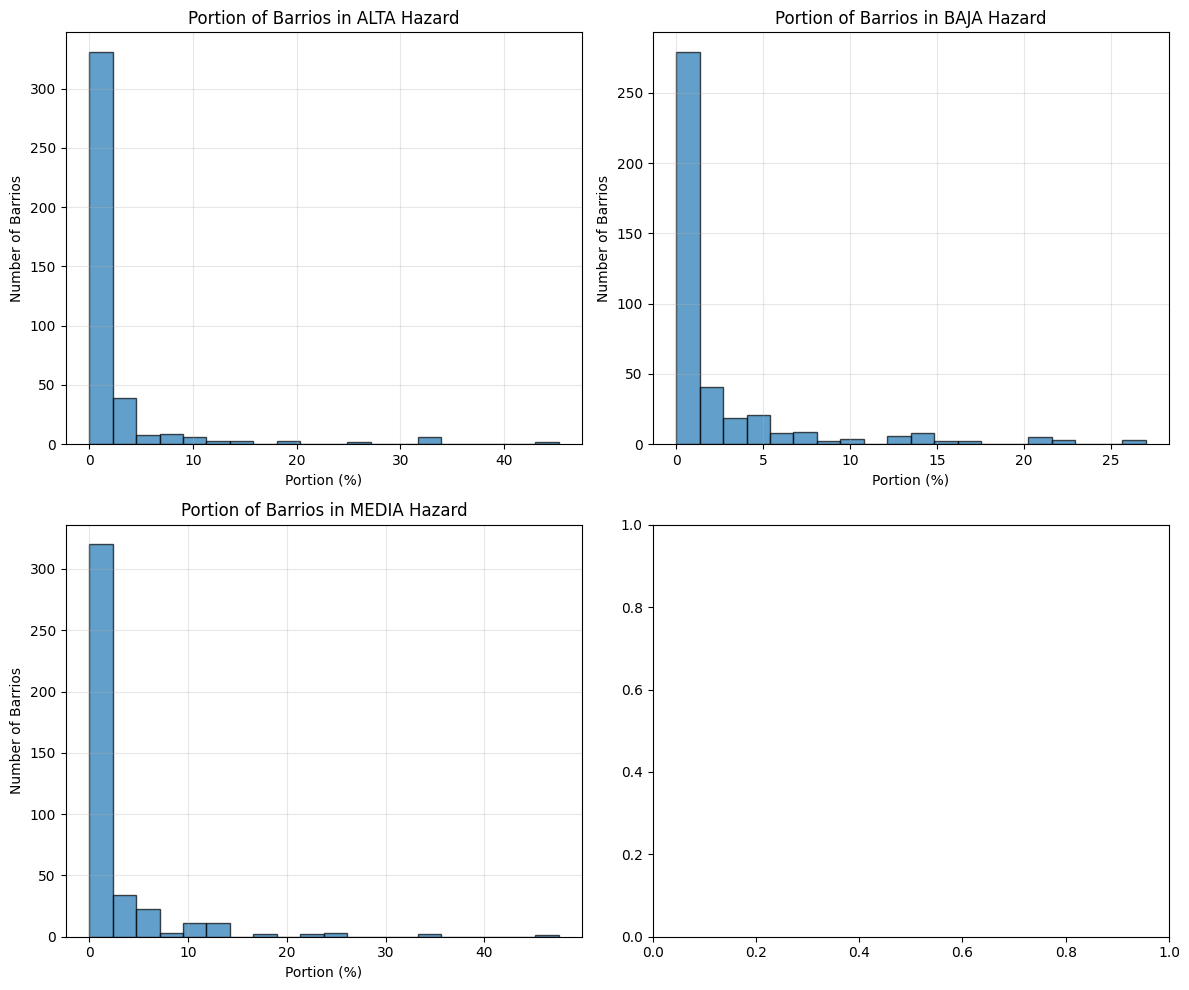

ALTA: Mean=2.2%, Max=45.3%, Barrios with >0%: 258
BAJA: Mean=2.4%, Max=27.0%, Barrios with >0%: 378
MEDIA: Mean=2.4%, Max=47.5%, Barrios with >0%: 368


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure with subplots for each hazard level
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each hazard level
for i, level in enumerate(hazard_levels):
    data = renabap_pba_intersect[f'porcion_{level}'] * 100  # Convert to percentage
    axes[i].hist(data, bins=20, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Portion of Barrios in {level.upper()} Hazard')
    axes[i].set_xlabel('Portion (%)')
    axes[i].set_ylabel('Number of Barrios')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
for level in hazard_levels:
    data = renabap_pba_intersect[f'porcion_{level}'] * 100
    print(f"{level.upper()}: Mean={data.mean():.1f}%, Max={data.max():.1f}%, Barrios with >0%: {(data > 0).sum()}")

In [9]:
# Calculate families exposed to each hazard level
for level in hazard_levels:
    renabap_pba_intersect[f'familias_expuestas_{level}'] = (
        renabap_pba_intersect[f'porcion_{level}'] * renabap_pba_intersect['familias_aproximadas']
    )

# Summary
total_familias = renabap_pba_intersect['familias_aproximadas'].sum()
print(f"Total families in dataset: {total_familias:.0f}")

for level in hazard_levels:
    total_exposed = renabap_pba_intersect[f'familias_expuestas_{level}'].sum()
    print(f"Total families exposed to {level} hazard: {total_exposed:.0f}")

Total families in dataset: 116184
Total families exposed to alta hazard: 2752
Total families exposed to baja hazard: 4011
Total families exposed to media hazard: 4038


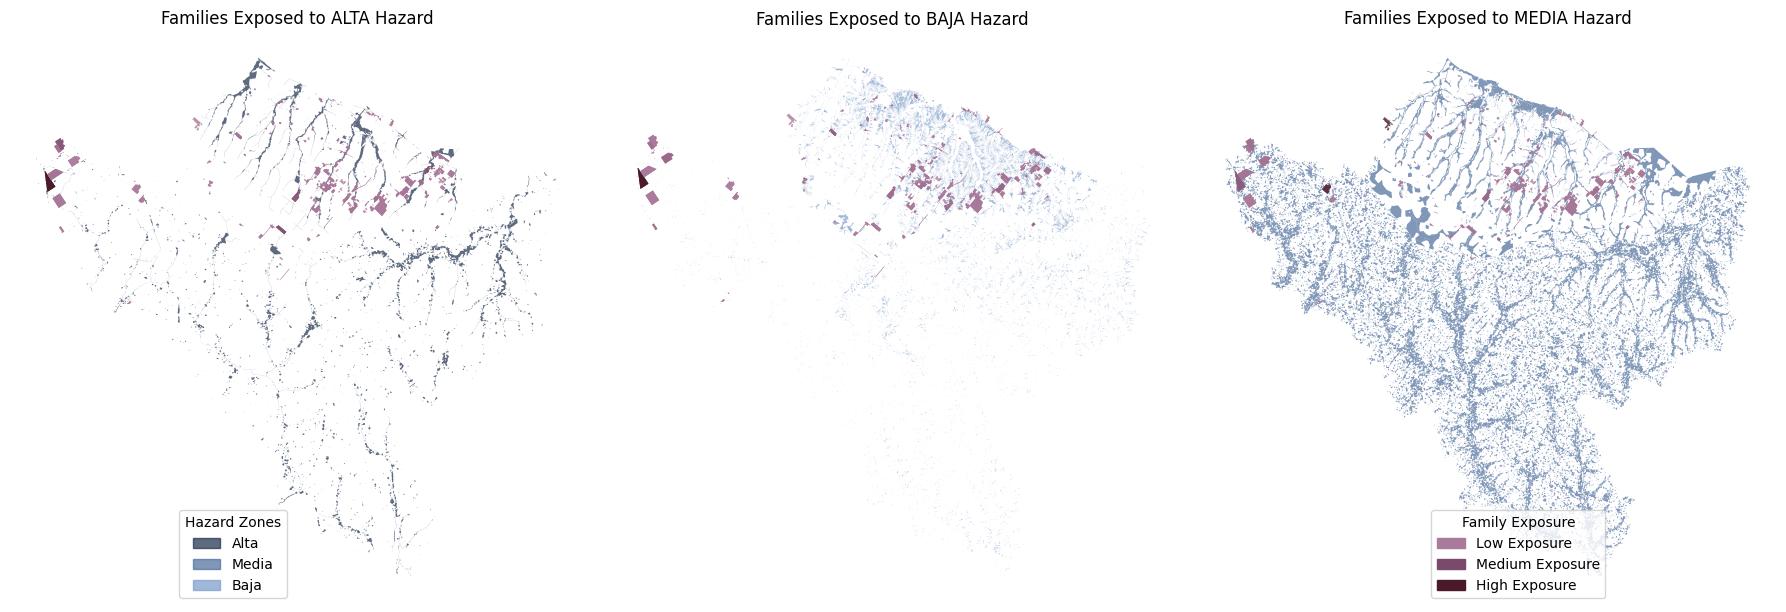

ALTA: Max=201 families, Mean=6.7 families, Barrios with exposure: 258
BAJA: Max=338 families, Mean=9.7 families, Barrios with exposure: 378
MEDIA: Max=419 families, Mean=9.8 families, Barrios with exposure: 368


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

# Create a single figure with subplots for each hazard level
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors based on your specifications
colors = {
    'alta': '#1a2b4a',      # hsla(221, 83%, 25%, 0.7) -> dark blue
    'media': '#4a6b9a',     # hsla(221, 83%, 45%, 0.7) -> medium blue  
    'baja': '#7a9bca'       # hsla(221, 83%, 65%, 0.7) -> light blue
}

# Define pink colors for exposure (exact hsla values you specified)
pink_colors = {
    'alta': '#4a1a2a',      # hsla(330, 83%, 25%, 0.7) -> dark pink
    'media': '#7a4a6a',     # hsla(330, 83%, 45%, 0.7) -> medium pink
    'baja': '#aa7a9a'       # hsla(330, 83%, 65%, 0.7) -> light pink
}

# Create custom pink colormap using your exact colors
pink_cmap = LinearSegmentedColormap.from_list('pink_custom', 
                                             [pink_colors['baja'], pink_colors['media'], pink_colors['alta']])

# Plot map for each hazard level
for i, level in enumerate(hazard_levels):
    # First plot the hazard polygons (peligro) as background
    peligro_subset = peligro[peligro['PELIGROSID'] == level]
    if not peligro_subset.empty:
        peligro_subset.plot(
            ax=axes[i],
            color=colors[level],
            alpha=0.7
        )
    
    # Then plot the barrio exposure data on top with your exact pink colors
    renabap_pba_intersect.plot(
        column=f'familias_expuestas_{level}',
        ax=axes[i],
        legend=False,
        cmap=pink_cmap,
        alpha=0.8,
        missing_kwds={'color': 'none', 'alpha': 0}
    )
    
    axes[i].set_title(f'Families Exposed to {level.upper()} Hazard')
    axes[i].axis('off')

# Create custom legend for hazard levels (blue)
hazard_legend_elements = [
    mpatches.Patch(color=colors['alta'], label='Alta', alpha=0.7),
    mpatches.Patch(color=colors['media'], label='Media', alpha=0.7),
    mpatches.Patch(color=colors['baja'], label='Baja', alpha=0.7)
]

# Create custom legend for exposure levels (pink gradient using your exact colors)
exposure_legend_elements = [
    mpatches.Patch(color=pink_colors['baja'], label='Low Exposure'),
    mpatches.Patch(color=pink_colors['media'], label='Medium Exposure'),
    mpatches.Patch(color=pink_colors['alta'], label='High Exposure')
]

# Add legends at the bottom
fig.legend(handles=hazard_legend_elements, loc='lower left', bbox_to_anchor=(0.1, 0.02), title='Hazard Zones')
fig.legend(handles=exposure_legend_elements, loc='lower right', bbox_to_anchor=(0.9, 0.02), title='Family Exposure')

plt.tight_layout()
plt.show()

# Print summary statistics for each map
for level in hazard_levels:
    data = renabap_pba_intersect[f'familias_expuestas_{level}']
    print(f"{level.upper()}: Max={data.max():.0f} families, Mean={data.mean():.1f} families, Barrios with exposure: {(data > 0).sum()}")

In [21]:
import rioxarray
import dask.array as da
from shapely.geometry import box

# Load GHSL data with dask chunking for memory efficiency
ghsl = rioxarray.open_rasterio(
    '/home/nissim/Downloads/spatial/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif',
    chunks={'x': 1024, 'y': 1024}  # Adjust chunk size based on your memory constraints
)

# Reproject to your target CRS with streaming
ghsl_3857 = ghsl.rio.reproject(
    dst_crs=USE_CRS
)

# Clip to peligro bounding box using streaming
bounding_box = box(*peligro.total_bounds)  # Create a box from the bounding box coordinates

ghsl_clipped = ghsl_3857.rio.clip(
    [bounding_box],  # Use the bounding box as a geometry (wrapped in a list)
    from_disk=True  # Process from disk to avoid loading entire dataset into memory
)


# If you need to compute the result (only when you actually need the data)
# ghsl_final = ghsl_clipped.compute()

In [ ]:

# take the ¨familias_aproximadas" column and combine with the population raster for dasymetric mapping
# do this by summing the total population estimated inside each barrio popular per the GHSL data
# then calculate the proportional value of each cell (as in, what fraction of the total population of the barrio popular it accounts for)
# and then get the adjusted population by multiplying that fraction by the total barrio population in familias_aproximadas


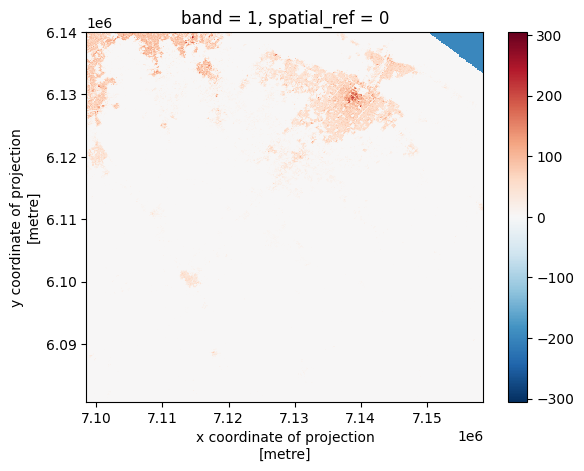

In [22]:
ghsl_clipped.plot()

In [18]:
ghsl_computed

<xarray.DataArray (band: 1, y: 721, x: 731)> Size: 4MB
array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]]],
      shape=(1, 721, 731))
Coordinates:
  * x            (x) float64 6kB 7.099e+06 7.099e+06 ... 7.158e+06 7.159e+06
  * y            (y) float64 6kB 6.14e+06 6.14e+06 ... 6.081e+06 6.081e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -200.0

In [23]:
import numpy as np
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Calculate the total GHSL population per barrio popular using zonal statistics
print("Calculating GHSL population totals per barrio popular...")
ghsl_totals = []
for geom in renabap_pba_intersect.geometry:
    # First, compute the GHSL data to materialize it
    ghsl_computed = ghsl_clipped.compute()

    ghsl_polygon = ghsl_clipped.rio.clip([geom], from_disk=True)
    ghsl_totals.append(ghsl_polygon.sum().values)

# Step 2: Rasterize the total GHSL population per barrio to match GHSL resolution
print("Rasterizing GHSL totals per barrio popular...")
ghsl_population_raster = ghsl_clipped.rio.rasterize(
    renabap_pba_intersect,
    column='familias_aproximadas',  # We'll replace this with ghsl_totals
    all_touched=True,
    fill=0
)

# Replace the familias_aproximadas values with ghsl_totals
ghsl_population_raster.values = np.array(ghsl_totals)[ghsl_population_raster.values.astype(int) - 1]

# Step 3: Create fractional GHSL population raster
print("Creating fractional GHSL population raster...")
fractional_ghsl_raster = ghsl_clipped / ghsl_population_raster

# Step 4: Rasterize the barrios populares polygons with 'familias_aproximadas' values
print("Rasterizing RENABAP familias_aproximadas...")
renabap_families_raster = ghsl_clipped.rio.rasterize(
    renabap_pba_intersect,
    column='familias_aproximadas',
    all_touched=True,
    fill=0
)

# Step 5: Multiply fractional GHSL raster by the barrios populares raster
print("Applying dasymetric mapping...")
final_raster = fractional_ghsl_raster * renabap_families_raster

# Apply the barrios populares mask to get NoData outside of the barrios
print("Applying barrios populares mask...")
renabap_mask = renabap_pba_intersect.geometry.union_all()
renabap_raster_mask = ghsl_clipped.rio.rasterize(
    [renabap_mask],
    all_touched=True,
    fill=0,
    dtype=np.uint8
)

# Mask the final raster so that only cells within barrios populares are considered
final_result = final_raster.where(renabap_raster_mask > 0)

# Step 6: Final output and statistics
print("Dasymetric mapping completed!")

# Summary statistics
total_families_in_renabap = renabap_pba_intersect['familias_aproximadas'].sum()
total_families_in_result = final_result.sum().values
print(f"Total families in RENABAP: {total_families_in_renabap}")
print(f"Total families in result: {total_families_in_result:.2f}")

# Step 7: Plot the result
plt.figure(figsize=(12, 8))
final_result.plot(cmap='YlOrRd', title='RENABAP Families - Dasymetric Mapping (100m)')
plt.colorbar(label='Families per 100m cell')
plt.show()

Calculating GHSL population totals per barrio popular...


NoDataInBounds: No data found in bounds.

In [ ]:


# Step 2: Rasterize the total GHSL population per barrio to match GHSL resolution
print("Rasterizing GHSL totals per barrio popular...")
ghsl_population_raster = ghsl_clipped.rio.rasterize(
    renabap_pba_intersect,
    column='familias_aproximadas',  # We'll replace this with ghsl_totals
    all_touched=True,
    fill=0
)

# Replace the familias_aproximadas values with ghsl_totals
ghsl_population_raster.values = np.array(ghsl_totals)[ghsl_population_raster.values.astype(int) - 1]

# Step 3: Create fractional GHSL population raster
print("Creating fractional GHSL population raster...")
fractional_ghsl_raster = ghsl_clipped / ghsl_population_raster

# Step 4: Rasterize the barrios populares polygons with 'familias_aproximadas' values
print("Rasterizing RENABAP familias_aproximadas...")
renabap_families_raster = ghsl_clipped.rio.rasterize(
    renabap_pba_intersect,
    column='familias_aproximadas',
    all_touched=True,
    fill=0
)

# Step 5: Multiply fractional GHSL raster by the barrios populares raster
print("Applying dasymetric mapping...")
final_raster = fractional_ghsl_raster * renabap_families_raster

# Apply the barrios populares mask to get NoData outside of the barrios
print("Applying barrios populares mask...")
renabap_mask = renabap_pba_intersect.geometry.union_all()
renabap_raster_mask = ghsl_clipped.rio.rasterize(
    [renabap_mask],
    all_touched=True,
    fill=0,
    dtype=np.uint8
)

# Mask the final raster so that only cells within barrios populares are considered
final_result = final_raster.where(renabap_raster_mask > 0)

# Step 6: Final output and statistics
print("Dasymetric mapping completed!")

# Summary statistics
total_families_in_renabap = renabap_pba_intersect['familias_aproximadas'].sum()
total_families_in_result = final_result.sum().values
print(f"Total families in RENABAP: {total_families_in_renabap}")
print(f"Total families in result: {total_families_in_result:.2f}")

# Step 7: Plot the result
plt.figure(figsize=(12, 8))
final_result.plot(cmap='YlOrRd', title='RENABAP Families - Dasymetric Mapping (100m)')
plt.colorbar(label='Families per 100m cell')
plt.show()

Creating barrios populares mask...


AttributeError: module 'rioxarray' has no attribute 'rasterize'